In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
from data_processor import load_features_and_split3, class_weight_hint  # your helper

print("xgboost version:", xgb.__version__)

# 1) Data
X_train, X_val, X_test, y_train, y_val, y_test = load_features_and_split3(
    "orbit_results_sobol_4.csv", test_size=0.20, val_size=0.10, random_state=42, stratify=True
)
spw = class_weight_hint(y_train)

# 2) DMatrices (pass feature names for nicer importances)
feat_names = list(X_train.columns)
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feat_names)
dval   = xgb.DMatrix(X_val,   label=y_val,   feature_names=feat_names)
dtest  = xgb.DMatrix(X_test,  label=y_test,  feature_names=feat_names)

# 3) Params (mirror your sklearn config)
params = {
    "objective": "binary:logistic",
    "eval_metric": ["auc", "logloss"],
    "eta": 0.03,                # learning_rate
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "scale_pos_weight": spw,    # helps with imbalance
    "verbosity": 0
}


xgboost version: 2.1.4


In [2]:
print("n_unique per feature:\n", X_train.nunique())
print("\nstd per feature:\n", X_train.std(numeric_only=True))
print("\npairwise corr (abs):\n", X_train.corr(numeric_only=True).abs())


n_unique per feature:
 r0            7000
v0            7000
cos_dtheta    7000
sin_dtheta    7000
mass          7000
rTarget       7000
dtype: int64

std per feature:
 r0            20.184001
v0             4.302308
cos_dtheta     0.022012
sin_dtheta     0.154433
mass           0.288501
rTarget        5.480049
dtype: float64

pairwise corr (abs):
                   r0        v0  cos_dtheta  sin_dtheta      mass   rTarget
r0          1.000000  0.005578    0.385776    0.035464  0.011120  0.000146
v0          0.005578  1.000000    0.008294    0.014091  0.007774  0.002925
cos_dtheta  0.385776  0.008294    1.000000    0.057485  0.012549  0.464605
sin_dtheta  0.035464  0.014091    0.057485    1.000000  0.008376  0.008836
mass        0.011120  0.007774    0.012549    0.008376  1.000000  0.000462
rTarget     0.000146  0.002925    0.464605    0.008836  0.000462  1.000000


In [3]:
# 4) Train with early stopping on the validation set
num_boost_round = 2000
evals_result = {}       
watchlist = [(dtrain, "train"), (dval, "val")]
booster = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=watchlist,
    evals_result=evals_result,     
    early_stopping_rounds=100,   # patience
    verbose_eval=False
)


In [4]:
# 5) Predict on test using the best iteration (robust)
best_iter = getattr(booster, "best_iteration", None)
if best_iter is None:
    # Fallback: use last recorded round from evals_result (requires you logged it)
    try:
        best_iter = len(evals_result["val"]["logloss"]) - 1
    except Exception:
        best_iter = 0  # ultra-conservative fallback

try:
    proba = booster.predict(dtest, iteration_range=(0, best_iter + 1))
except TypeError:
    # Older XGBoost: use ntree_limit fallback
    ntree_limit = getattr(booster, "best_ntree_limit", best_iter + 1)
    proba = booster.predict(dtest, ntree_limit=ntree_limit)

pred = (proba >= 0.5).astype(int)


Best iteration: 1487
Test ROC AUC: 0.9405
Test PR  AUC: 0.6741

Classification report:
               precision    recall  f1-score   support

           0      0.963     0.903     0.932      1696
           1      0.599     0.809     0.688       304

    accuracy                          0.888      2000
   macro avg      0.781     0.856     0.810      2000
weighted avg      0.908     0.888     0.895      2000



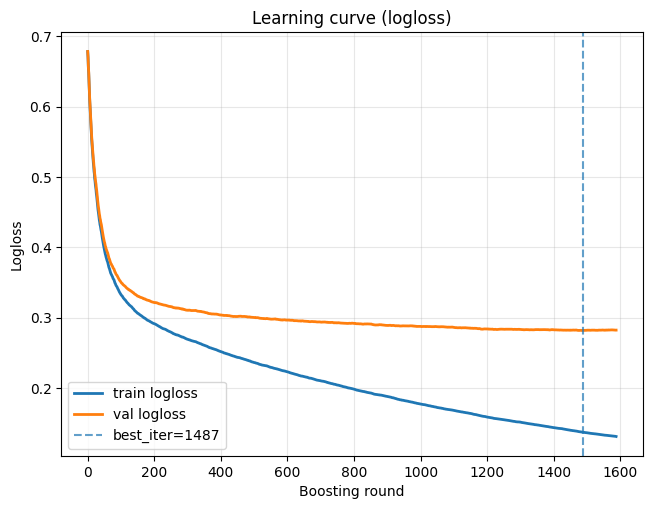

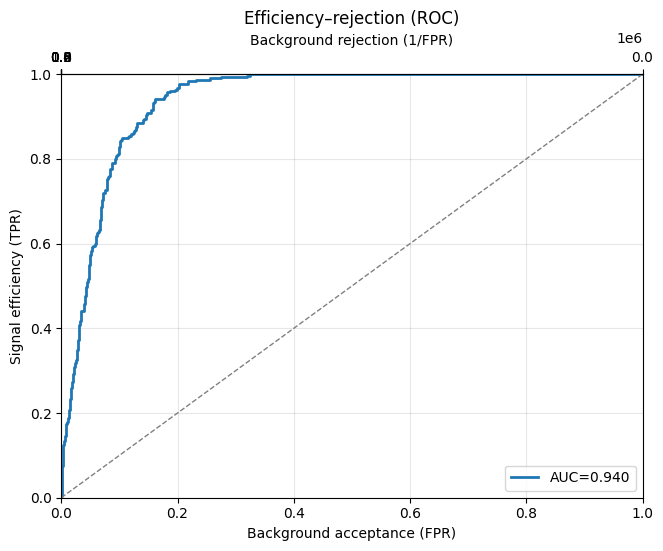

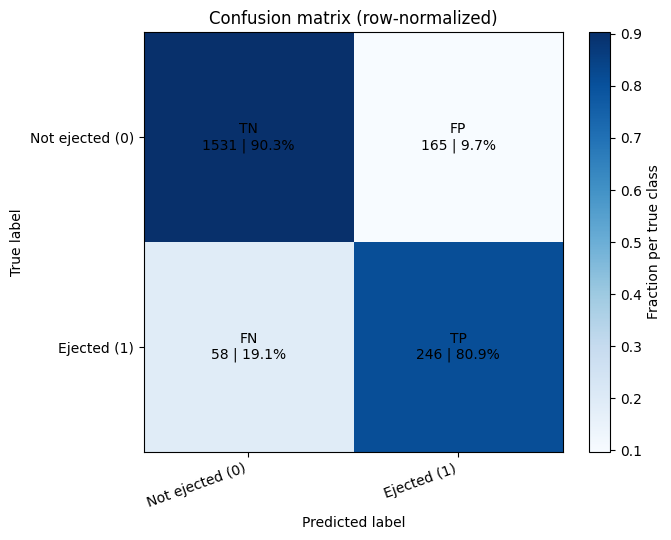

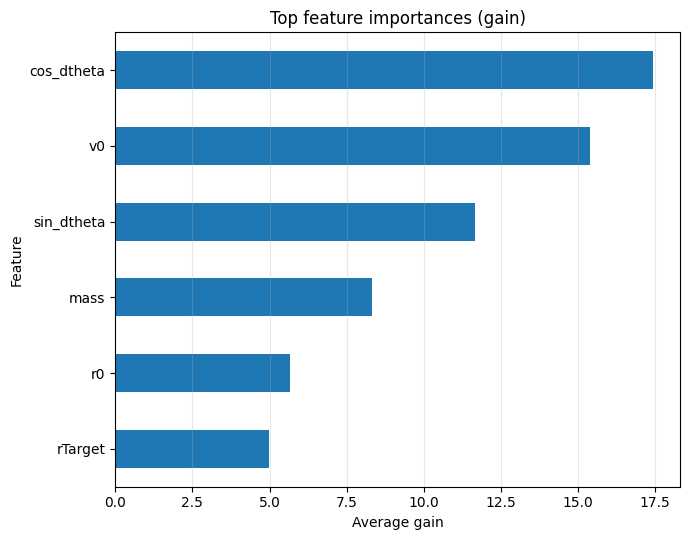

In [5]:
# === 6) Metrics & Plots ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix, roc_curve

# Use best iteration (from early stopping)
best_iter = getattr(booster, "best_iteration", None)
if best_iter is None:
    best_iter = len(evals_result["val"]["auc"]) - 1

try:
    proba = booster.predict(dtest, iteration_range=(0, best_iter + 1))
except TypeError:
    proba = booster.predict(dtest, ntree_limit=getattr(booster, "best_ntree_limit", best_iter + 1))

pred = (proba >= 0.5).astype(int)

print(f"Best iteration: {best_iter}")
print(f"Test ROC AUC: {roc_auc_score(y_test, proba):.4f}")
print(f"Test PR  AUC: {average_precision_score(y_test, proba):.4f}")
print("\nClassification report:\n", classification_report(y_test, pred, digits=3))

# A) Learning curve: logloss vs boosting round
plt.rcParams["figure.figsize"] = (7.5, 5.5)
fig, ax = plt.subplots()
ax.plot(evals_result["train"]["logloss"], label="train logloss", lw=2)
ax.plot(evals_result["val"]["logloss"],   label="val logloss",   lw=2)
ax.axvline(best_iter, ls="--", alpha=0.7, label=f"best_iter={best_iter}")
ax.set_xlabel("Boosting round")
ax.set_ylabel("Logloss")
ax.set_title("Learning curve (logloss)")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

# B) ROC with background rejection (1/FPR) on top axis
fpr, tpr, _ = roc_curve(y_test, proba)
fig, ax = plt.subplots()
ax.plot(fpr, tpr, lw=2, label=f"AUC={roc_auc_score(y_test, proba):.3f}")
ax.plot([0,1], [0,1], ls="--", lw=1, color="gray")
ax.set_xlim(0, 1); ax.set_ylim(0, 1)
ax.set_xlabel("Background acceptance (FPR)")
ax.set_ylabel("Signal efficiency (TPR)")
ax.set_title("Efficiency–rejection (ROC)")
def fwd(fpr_vals):
    f = np.clip(np.array(fpr_vals), 1e-6, 1.0); return 1.0 / f
def inv(rej_vals):
    r = np.clip(np.array(rej_vals), 1.0, 1e6);  return 1.0 / r
secax = ax.secondary_xaxis('top', functions=(fwd, inv))
secax.set_xlabel("Background rejection (1/FPR)")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

# C) Pretty confusion matrix: counts + row-normalized %
cm  = confusion_matrix(y_test, pred)
cmn = cm / cm.sum(axis=1, keepdims=True)
labels = np.array([["TN", "FP"], ["FN", "TP"]])
classes = ["Not ejected (0)", "Ejected (1)"]

fig, ax = plt.subplots()
im = ax.imshow(cmn, cmap="Blues")
ax.set_title("Confusion matrix (row-normalized)")
ax.set_xticks([0,1], labels=classes, rotation=20, ha="right")
ax.set_yticks([0,1], labels=classes)
for (i, j), v in np.ndenumerate(cmn):
    ax.text(j, i, f"{labels[i,j]}\n{cm[i,j]} | {v*100:.1f}%", ha="center", va="center", fontsize=10)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Fraction per true class")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
plt.tight_layout()
plt.show()

# D) Top feature importances (gain)
gain = booster.get_score(importance_type="gain")
imp = pd.Series(gain, dtype=float).sort_values(ascending=False)
topk = imp.head(12)
fig, ax = plt.subplots(figsize=(7, 5.5))
topk.iloc[::-1].plot(kind="barh", ax=ax)
ax.set_xlabel("Average gain")
ax.set_ylabel("Feature")
ax.set_title("Top feature importances (gain)")
ax.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


In [10]:
# --- Save ---
import os, json

os.makedirs("artifacts", exist_ok=True)

# 1) model
booster.save_model("artifacts/bdt_model.json")  # or "bdt_model.ubj" for binary json

# 2) metadata
bdt_meta = {
    "framework": "xgboost",
    "xgboost_version": xgb.__version__,
    "model_file": "bdt_model.json",
    "feature_names": list(feat_names),   # preserve exact order
    "best_iteration": int(best_iter),
    "params": params,
    "threshold": 0.5,                    # decision threshold you used for pred
    # optional extras:
    # "class_weight_hint": float(spw),
    # "metrics": {"roc_auc": float(...), "pr_auc": float(...), ...},
    # "random_state": 42,
}
with open("artifacts/bdt_meta.json", "w") as f:
    json.dump(bdt_meta, f, indent=2)
print("Saved artifacts/bdt_model.json and artifacts/bdt_meta.json")


Saved artifacts/bdt_model.json and artifacts/bdt_meta.json
